In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
# Change this path to point to the specific run you want to analyze (e.g., 70M or 160M)
DETAILS_CSV = "wikipedia/experiments/ADPT_run_r16_pythia410m/results/canary_details_full.csv" 
#TODO CAMBIARE
ORIGINAL_CANARIES_CSV = "memorization/canaries.csv" 

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

In [18]:
def load_data(details_path, meta_path):
    if not os.path.exists(details_path) or not os.path.exists(meta_path):
        print(f"❌ ERROR: Files not found at:\n{details_path}\n{meta_path}")
        return None

    print("✅ Loading files...")
    df_details = pd.read_csv(details_path)
    df_meta = pd.read_csv(meta_path)

    # Merge to get 'type' column (High/Low Entropy)
    # We merge on 'canary_id'
    df_merged = pd.merge(df_details, df_meta[['canary_id', 'type']], on='canary_id', how='left')
    
    # Check if exact_match exists
    if 'exact_match' not in df_merged.columns:
        print("⚠️ WARNING: 'exact_match' column not found. Filling with 0.")
        df_merged['exact_match'] = 0

    print(f"Merged Data Ready: {len(df_merged)} rows.")
    return df_merged

# Execute Load
df_data = load_data(DETAILS_CSV, ORIGINAL_CANARIES_CSV)
df_data.head()

✅ Loading files...
Merged Data Ready: 1200 rows.


,epoch,canary_id,global_loss_tgt,suffix_loss_tgt,exact_match,split,suffix_loss_ref,global_loss_ref,loss_optimum,mia_score,counterfactual_score,contextual_score,type
0,0,le_073aa1,5.716645,4.935062,0,validation,4.721948,5.614631,4.721948,-0.213115,0.000000,0.0,low_entropy
1,0,he_3c82e8,5.574387,5.249785,0,train,5.218369,5.551909,5.218369,-0.031416,0.000000,0.0,high_entropy
2,0,he_b6c479,5.625305,5.334650,0,train,5.405127,5.676463,5.256312,0.070477,0.013039,0.0,high_entropy
3,0,le_30e20c,4.183772,3.781574,0,validation,3.675069,4.095931,3.675069,-0.106504,0.000000,0.0,low_entropy
4,0,he_fa06a9,6.564626,6.580880,0,train,6.600027,6.561135,6.555809,0.019146,0.002901,0.0,high_entropy


In [19]:
def calculate_dynamic_threshold(scores, fpr_target=0.10):
    """
    Calculates the threshold at the (1-FPR) percentile of the validation scores.
    """
    if len(scores) == 0: return float('inf')
    return np.percentile(scores, (1 - fpr_target) * 100)

def analyze_subset_metrics(df_subset):
    stats = []
    epochs = sorted(df_subset['epoch'].unique())
    
    for epoch in epochs:
        df_epoch = df_subset[df_subset['epoch'] == epoch]
        
        # 1. Split Data
        val_data = df_epoch[df_epoch['split'] == 'validation']
        train_data = df_epoch[df_epoch['split'] == 'train']
        
        # Skip if missing data
        if len(val_data) == 0 or len(train_data) == 0: 
            continue
            
        # 2. Calibrate MIA Threshold using VALIDATION set (Non-members)
        # We want 10% False Positive Rate on non-members
        tau = calculate_dynamic_threshold(val_data['mia_score'].values, fpr_target=0.10)
        
        # 3. Calculate Metrics on TRAINING set (Members)
        
        # A. MIA Recall
        is_memorized = train_data['mia_score'] > tau
        mia_recall = is_memorized.sum() / len(train_data)
        
        # B. Contextual & Counterfactual (Averages)
        avg_ctx = train_data['contextual_score'].mean()
        avg_cf = train_data['counterfactual_score'].mean()
        
        # C. Exact Match (Biderman / Extractability)
        # This is the percentage of training canaries generated verbatim
        if 'exact_match' in train_data.columns:
            extractability = train_data['exact_match'].mean()
        else:
            extractability = 0.0
        
        stats.append({
            'epoch': epoch, 
            'mia_recall': mia_recall, 
            'contextual_score': avg_ctx, 
            'counterfactual_score': avg_cf,
            'extractability': extractability
        })
        
    return pd.DataFrame(stats)

In [20]:
def plot_comparison(df_stats, title):
    if df_stats.empty:
        print(f"⚠️ No data to plot for {title}")
        return

    plt.figure(figsize=(12, 7))
    
    # 1. MIA Recall (Red)
    sns.lineplot(data=df_stats, x='epoch', y='mia_recall', label='MIA Recall', 
                 linewidth=2, color='crimson', alpha=0.6)
    
    # 2. Counterfactual (Green)
    sns.lineplot(data=df_stats, x='epoch', y='counterfactual_score', label='Counterfactual', 
                 linewidth=2, linestyle='-.', color='green', alpha=0.6)
    
    # 3. Contextual (Blue - Your Main Metric)
    sns.lineplot(data=df_stats, x='epoch', y='contextual_score', label='Contextual', 
                 linewidth=3, marker='s', color='royalblue')
    

    plt.title(title, fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Training Epochs", fontsize=14)
    plt.ylabel("Score (0.0 - 1.0)", fontsize=14)
    
    # Set limits slightly wider to see points clearly
    plt.ylim(-0.05, 1.05)
    plt.xticks(df_stats['epoch'].unique())
    
    plt.legend(loc='center right', fontsize=12, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

--- Analyzing High Entropy Canaries ---


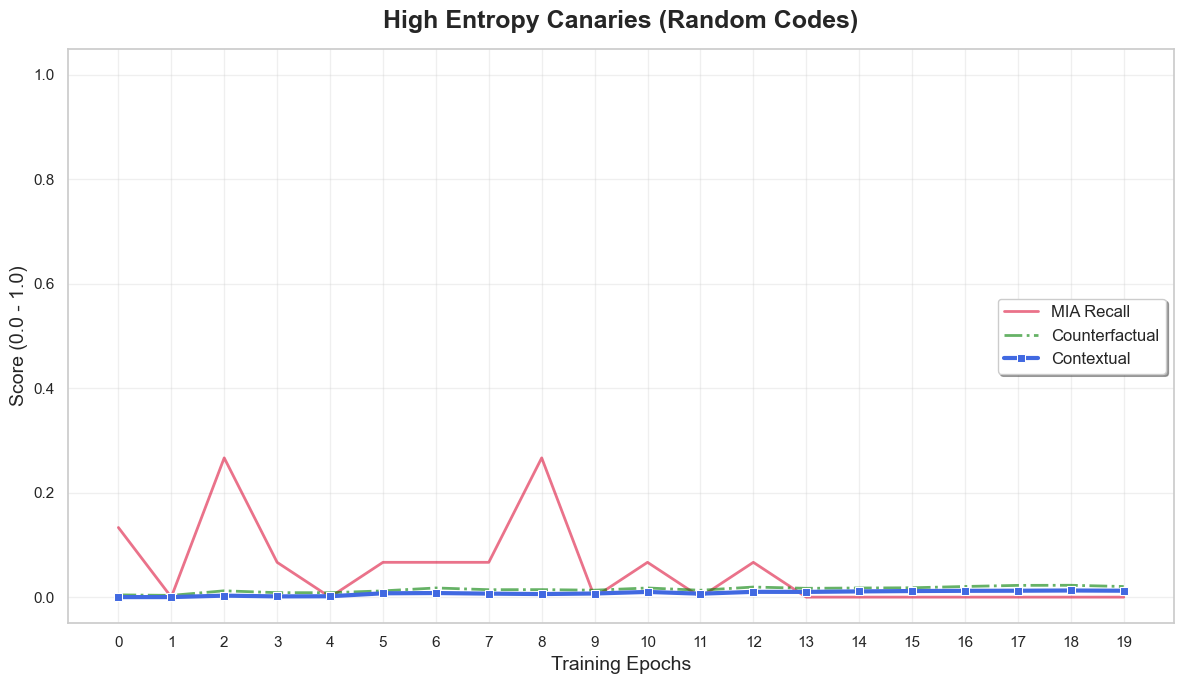

    epoch  mia_recall  contextual_score  counterfactual_score  extractability
19     19         0.0          0.012289               0.02036             0.0




In [21]:
if df_data is not None:
    # --- ANALYSIS 1: HIGH ENTROPY (Random Codes) ---
    print("--- Analyzing High Entropy Canaries ---")
    df_high = df_data[df_data['type'] == 'high_entropy']
    
    if not df_high.empty:
        stats_high = analyze_subset_metrics(df_high)
        plot_comparison(stats_high, "High Entropy Canaries (Random Codes)")
        # Optional: Print last epoch stats
        print(stats_high.tail(1))
    else:
        print("No High Entropy data found.")

    print("\n" + "="*50 + "\n")



--- Analyzing Low Entropy Canaries ---


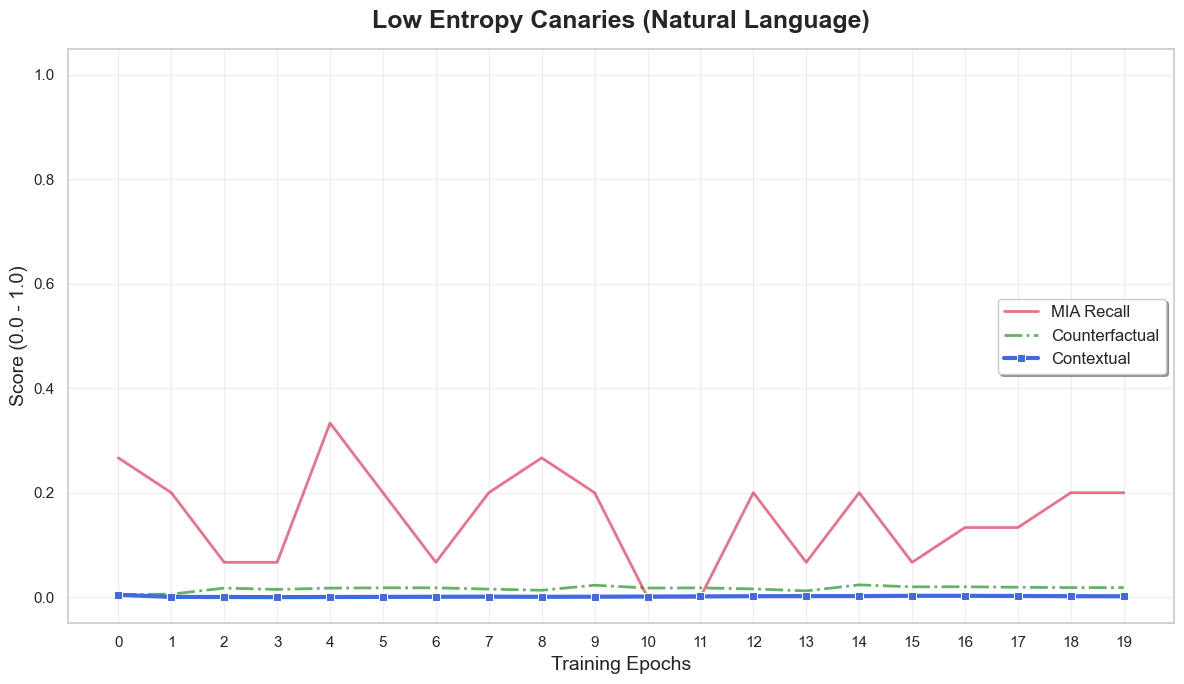

    epoch  mia_recall  contextual_score  counterfactual_score  extractability
19     19         0.2          0.001643              0.018246             0.0


In [22]:
# --- ANALYSIS 2: LOW ENTROPY (Natural Language) ---
print("--- Analyzing Low Entropy Canaries ---")
df_low = df_data[df_data['type'] == 'low_entropy']

if not df_low.empty:
    stats_low = analyze_subset_metrics(df_low)
    plot_comparison(stats_low, "Low Entropy Canaries (Natural Language)")
    # Optional: Print last epoch stats
    print(stats_low.tail(1))
else:
    print("No Low Entropy data found.")

--- Visualizzazione Exact Match: High Entropy ---


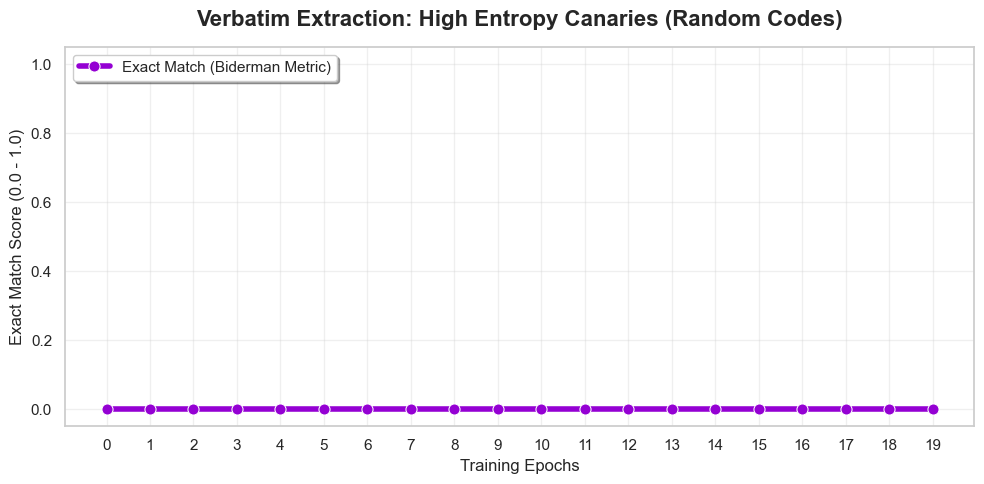

--- Visualizzazione Exact Match: Low Entropy ---


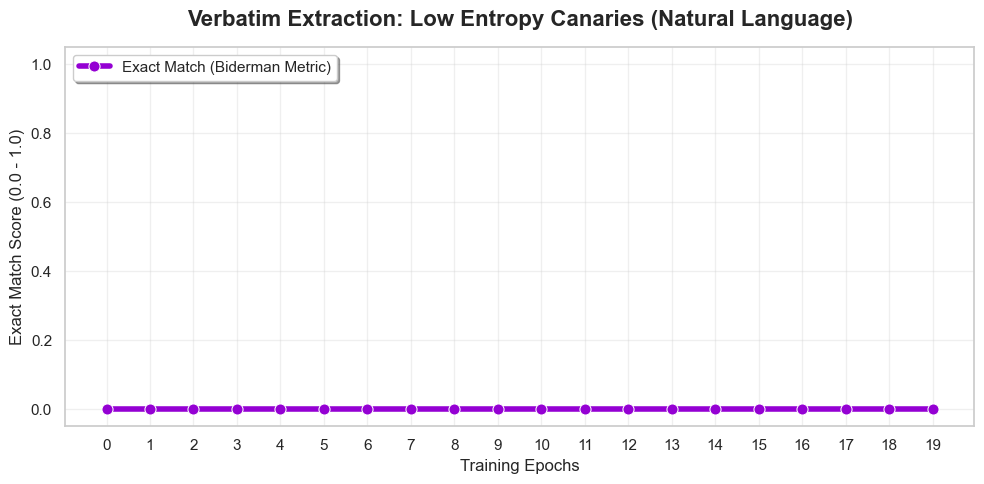

In [23]:
# --- NUOVO BLOCCO: SOLO EXACT MATCH ANALYSIS ---

def plot_exact_match_only(df_stats, title):
    """
    Plotta esclusivamente la metrica di Exact Match (Biderman).
    """
    if df_stats.empty:
        print(f"⚠️ No data to plot for {title}")
        return

    plt.figure(figsize=(10, 5))

    # Plot dell'Exact Match (chiamato 'extractability' nel DataFrame stats)
    sns.lineplot(
        data=df_stats,
        x='epoch',
        y='extractability',
        label='Exact Match (Biderman Metric)',
        linewidth=4,
        marker='o',
        markersize=8,
        color='darkviolet'  # Viola richiesto
    )

    plt.title(f"Verbatim Extraction: {title}", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Training Epochs", fontsize=12)
    plt.ylabel("Exact Match Score (0.0 - 1.0)", fontsize=12)

    # Range fisso 0-1
    plt.ylim(-0.05, 1.05)
    plt.xticks(df_stats['epoch'].unique())

    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- ESECUZIONE ---
if 'stats_high' in locals() and not stats_high.empty:
    print("--- Visualizzazione Exact Match: High Entropy ---")
    plot_exact_match_only(stats_high, "High Entropy Canaries (Random Codes)")

if 'stats_low' in locals() and not stats_low.empty:
    print("--- Visualizzazione Exact Match: Low Entropy ---")
    plot_exact_match_only(stats_low, "Low Entropy Canaries (Natural Language)")

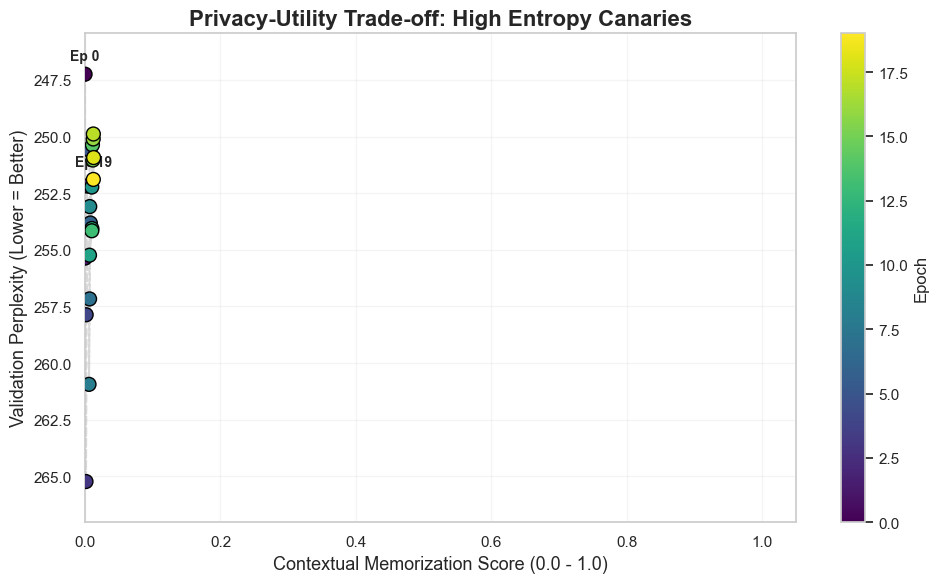

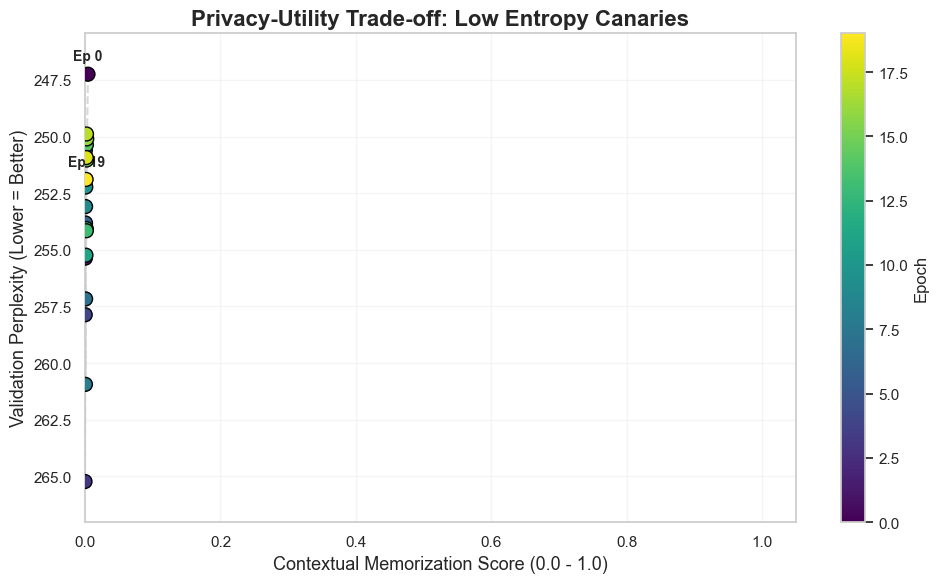

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DEFINIZIONE FUNZIONE DI CARICAMENTO ---
def load_summary_metrics(path):
    """
    Carica il file metrics_summary.csv che contiene la perplexity per epoca.
    """
    if not os.path.exists(path):
        print(f"❌ ERROR: Summary file not found at: {path}")
        return None
    
    df_summary = pd.read_csv(path)
    
    # Verifichiamo il nome della colonna (tu hai indicato 'avg_perplexity')
    if 'avg_perplexity' not in df_summary.columns:
        print(f"⚠️ Warning: 'avg_perplexity' not found. Columns available: {df_summary.columns.tolist()}")
        return None
        
    return df_summary[['epoch', 'avg_perplexity']]

# --- 2. CONFIGURAZIONE PERCORSI E CARICAMENTO ---
# RESULTS_DIR è la cartella dove si trova canary_details_full.csv
RESULTS_DIR = os.path.dirname(DETAILS_CSV)
SUMMARY_PATH = os.path.join(RESULTS_DIR, "metrics_summary.csv")

# Carichiamo i dati della perplexity globale
df_summary_ppl = load_summary_metrics(SUMMARY_PATH)

# --- 3. DEFINIZIONE FUNZIONI DI PLOTTING ---
def get_global_limits(df_high_stats, df_low_stats, df_ppl):
    """
    Calcola i limiti comuni per rendere i grafici confrontabili.
    """
    # Asse X: sempre 0-1 per la memorizzazione
    x_lim = (0.0, 1.05) 
    
    # Asse Y: calcoliamo il range della perplexity
    if df_ppl is not None:
        y_min = df_ppl['avg_perplexity'].min()
        y_max = df_ppl['avg_perplexity'].max()
        margin = (y_max - y_min) * 0.1 # Margine del 10%
        y_lim = (y_min - margin, y_max + margin)
    else:
        y_lim = (None, None)
    return x_lim, y_lim

def plot_perplexity_vs_memorization(df_stats, df_ppl, title, x_lim, y_lim):
    if df_stats.empty or df_ppl is None:
        print(f"⚠️ Skipping {title}: Missing data.")
        return

    # Uniamo i dati delle canaries con la perplexity per epoca
    df_plot = pd.merge(df_stats, df_ppl, on='epoch')

    plt.figure(figsize=(10, 6))
    
    # Traiettoria
    plt.plot(df_plot['contextual_score'], df_plot['avg_perplexity'], 
             color='gray', linestyle='--', alpha=0.3)
    
    # Punti colorati per epoca
    scatter = plt.scatter(df_plot['contextual_score'], df_plot['avg_perplexity'], 
                          c=df_plot['epoch'], cmap='viridis', s=100, 
                          edgecolor='black', zorder=5)
    
    # Annotazioni Epoca 0 e Ultima
    for i, txt in enumerate(df_plot['epoch']):
        if i == 0 or i == len(df_plot)-1:
            plt.annotate(f"Ep {txt}", (df_plot['contextual_score'].iloc[i], df_plot['avg_perplexity'].iloc[i]), 
                         textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.gca().invert_yaxis() # Più bassa è la PPL, più è "in alto" l'utilità nel grafico

    plt.title(f"Privacy-Utility Trade-off: {title}", fontsize=16, fontweight='bold')
    plt.xlabel("Contextual Memorization Score (0.0 - 1.0)", fontsize=13)
    plt.ylabel("Validation Perplexity (Lower = Better)", fontsize=13)
    
    plt.colorbar(scatter, label='Epoch')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# --- 4. ESECUZIONE ---
if df_summary_ppl is not None:
    # Calcoliamo i limiti globali basandoci su stats_high e stats_low caricate in precedenza
    # Nota: Assicurati di aver già eseguito le celle che generano stats_high e stats_low
    global_x_lim, global_y_lim = get_global_limits(stats_high, stats_low, df_summary_ppl)

    if not stats_high.empty:
        plot_perplexity_vs_memorization(stats_high, df_summary_ppl, "High Entropy Canaries", global_x_lim, global_y_lim)
        
    if not stats_low.empty:
        plot_perplexity_vs_memorization(stats_low, df_summary_ppl, "Low Entropy Canaries", global_x_lim, global_y_lim)

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. SETTINGS ESTETICI ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid", {'axes.grid': True, 'grid.linestyle': '--', 'grid.color': '#e0e0e0'})

# Palette personalizzata
custom_palette = {
    "Pythia": "#2c3e50",  # Midnight Blue
    "GPT-2": "#d35400",   # Pumpkin Orange
    "Llama": "#27ae60"    # Nephrite Green
}

# Mapping markers per famiglia
family_markers = {"Pythia": "o", "GPT-2": "s", "Llama": "D"}

# --- 2. CONFIGURAZIONE PERCORSI ---
run_mapping = {
    'run_pythia70m': (70, 'Pythia'),
    'run_pythia160m': (160, 'Pythia'),
    'run_pythia410m': (410, 'Pythia'),
    'run_pythia1b': (1000, 'Pythia'),
    'run_pythia1.4b': (1400, 'Pythia'),
    'run_gpt2small': (124, 'GPT-2'),
    'run_gpt2medium': (355, 'GPT-2'),
    'run_gpt2large': (774, 'GPT-2'),
    'run_gpt2xl': (1500, 'GPT-2'),
    'run_llama1b': (1200, 'Llama'),
    'run_tinyllama': (1100, 'Llama')
}

BASE_DIR = "wikipedia/experiments/"
processed_data = []

def get_mia_recall(df_subset):
    train_scores = df_subset[df_subset['split'] == 'train']['mia_score']
    val_scores = df_subset[df_subset['split'] == 'validation']['mia_score']
    if len(val_scores) < 2: return 0.0
    threshold = np.percentile(val_scores, 90)
    return (train_scores > threshold).mean()

# Caricamento dati
for folder, (size, family) in run_mapping.items():
    file_path = os.path.join(BASE_DIR, folder, "results", "canary_details_full.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        last_epoch = df['epoch'].max()
        df_last = df[df['epoch'] == last_epoch]
        
        for ent_label, prefix in [('High Entropy', 'he_'), ('Low Entropy', 'le_')]:
            subset = df_last[df_last['canary_id'].str.startswith(prefix)]
            if not subset.empty:
                train_subset = subset[subset['split'] == 'train']
                processed_data.append({
                    'size': size,
                    'family': family,
                    'entropy': ent_label,
                    'contextual_score': train_subset['contextual_score'].mean(),
                    'mia_recall': get_mia_recall(subset),
                    'perplexity': np.exp(train_subset['suffix_loss_tgt'].mean())
                })

df_master = pd.DataFrame(processed_data)

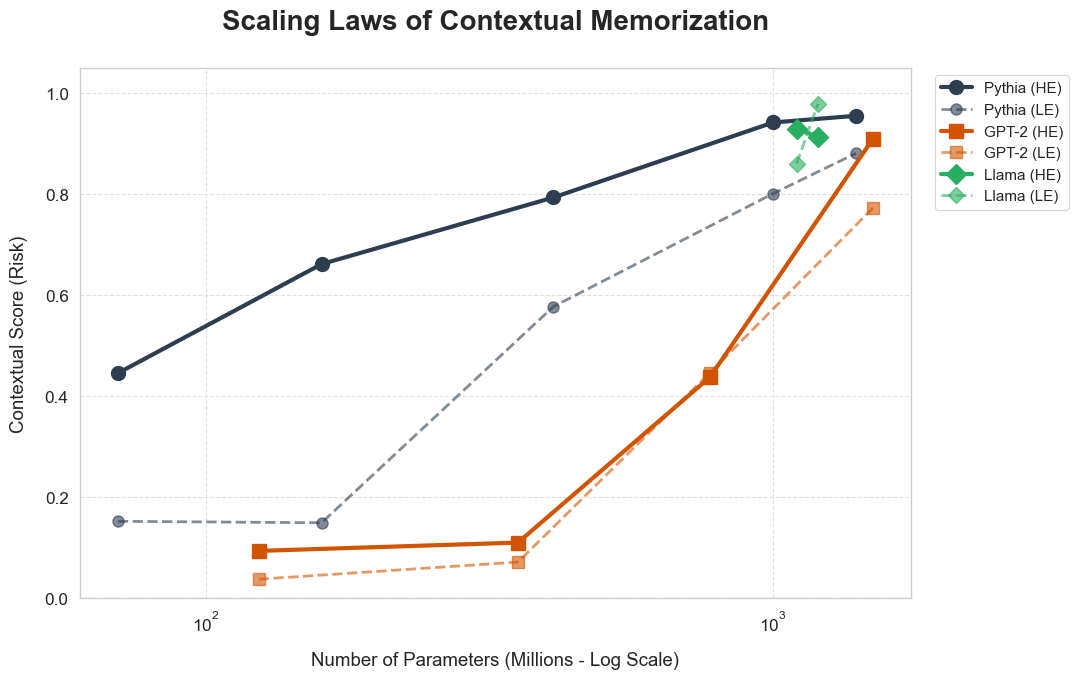

In [33]:
# --- 3. GRAFICO 1: SCALING LAWS (ESTETICA PREMIUM) ---
plt.figure(figsize=(11, 7))
for family, color in custom_palette.items():
    family_data = df_master[df_master['family'] == family]
    if family_data.empty: continue
    
    # High Entropy (Linea Continua)
    he_data = family_data[family_data['entropy'] == 'High Entropy'].sort_values('size')
    plt.plot(he_data['size'], he_data['contextual_score'], label=f"{family} (HE)", 
             marker=family_markers[family], color=color, linewidth=3, markersize=10)
    
    # Low Entropy (Linea Tratteggiata)
    le_data = family_data[family_data['entropy'] == 'Low Entropy'].sort_values('size')
    plt.plot(le_data['size'], le_data['contextual_score'], label=f"{family} (LE)", 
             marker=family_markers[family], color=color, linewidth=2, linestyle='--', alpha=0.6, markersize=8)

plt.xscale('log')
plt.ylim(0, 1.05)
plt.title("Scaling Laws of Contextual Memorization\n", fontsize=20, fontweight='bold')
plt.xlabel("Number of Parameters (Millions - Log Scale)", labelpad=12)
plt.ylabel("Contextual Score (Risk)", labelpad=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fontsize=11)
plt.tight_layout()
plt.savefig("thesis_scaling_laws.png", dpi=300)
plt.show()

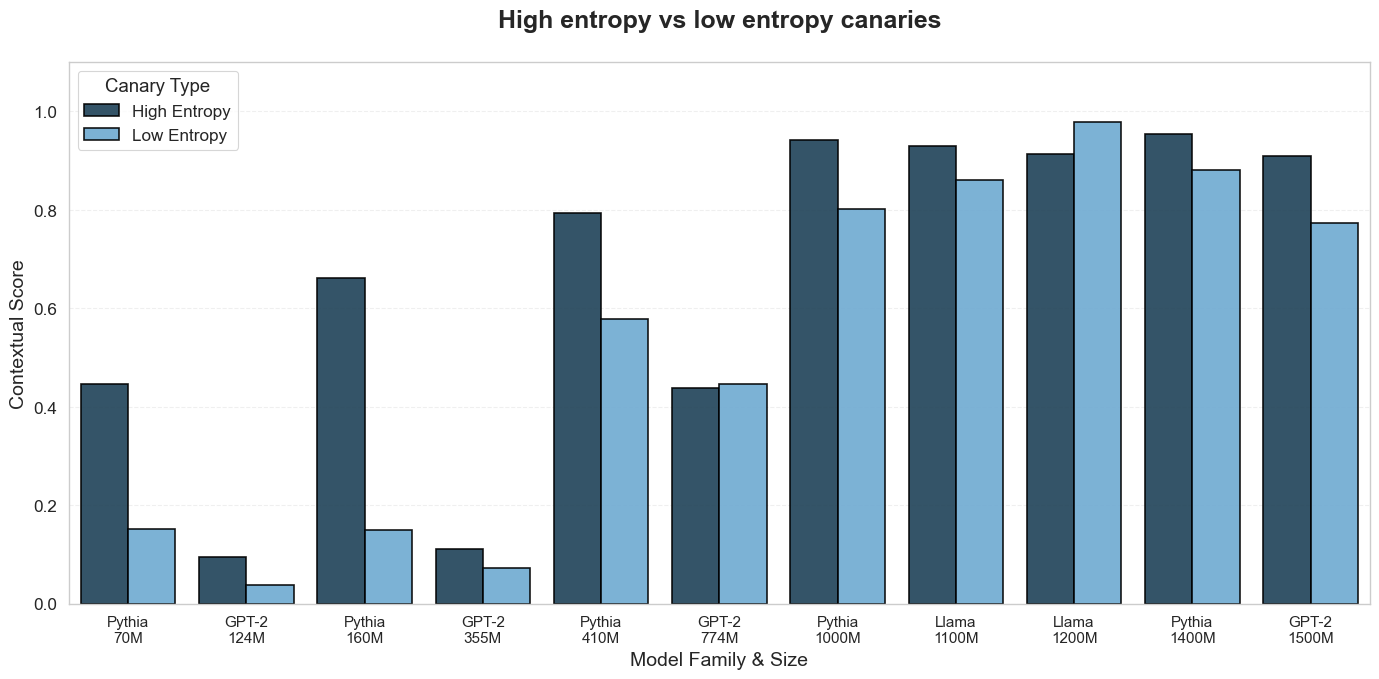

In [37]:
# --- GRAFICO 3: THE ENTROPY GAP (Updated X-Axis Labels) ---

plt.figure(figsize=(14, 7)) # Increased width slightly for better spacing

# 1. PRE-PROCESSING: Create a composite label for the X-axis
# This ensures "Pythia 70M" is treated differently from "GPT-2 124M"
df_master['x_label'] = df_master.apply(lambda row: f"{row['family']}\n{row['size']}M", axis=1)

# 2. SORTING: Important to keep the bars ordered by size
df_master = df_master.sort_values(by=['size', 'family'])

# 3. PALETTE: Blue tones (Light for Low Entropy, Dark for High Entropy)
# Note: You can swap the order if you want Dark for Low Entropy
blue_palette = {"High Entropy": "#154360", "Low Entropy": "#5DADE2"}

# 4. PLOTTING
bp = sns.barplot(
    data=df_master,
    x="x_label",        # Use the new combined label
    y="contextual_score",
    hue="entropy",
    palette=blue_palette,
    edgecolor="black",
    linewidth=1.2,
    alpha=0.9
)

plt.title("High entropy vs low entropy canaries\n", fontsize=18, fontweight='bold')
plt.xlabel("Model Family & Size", fontsize=14)
plt.ylabel("Contextual Score", fontsize=14)
plt.ylim(0, 1.1)

# X-Axis Ticks Adjustment
# We rotate them slightly if there are many models to prevent overlap
plt.xticks(fontsize=11, rotation=0) 

plt.legend(title="Canary Type", loc='upper left', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.5) # Horizontal grid only
plt.tight_layout()

plt.savefig("thesis_entropy_gap_labeled.png", dpi=300)
plt.show()

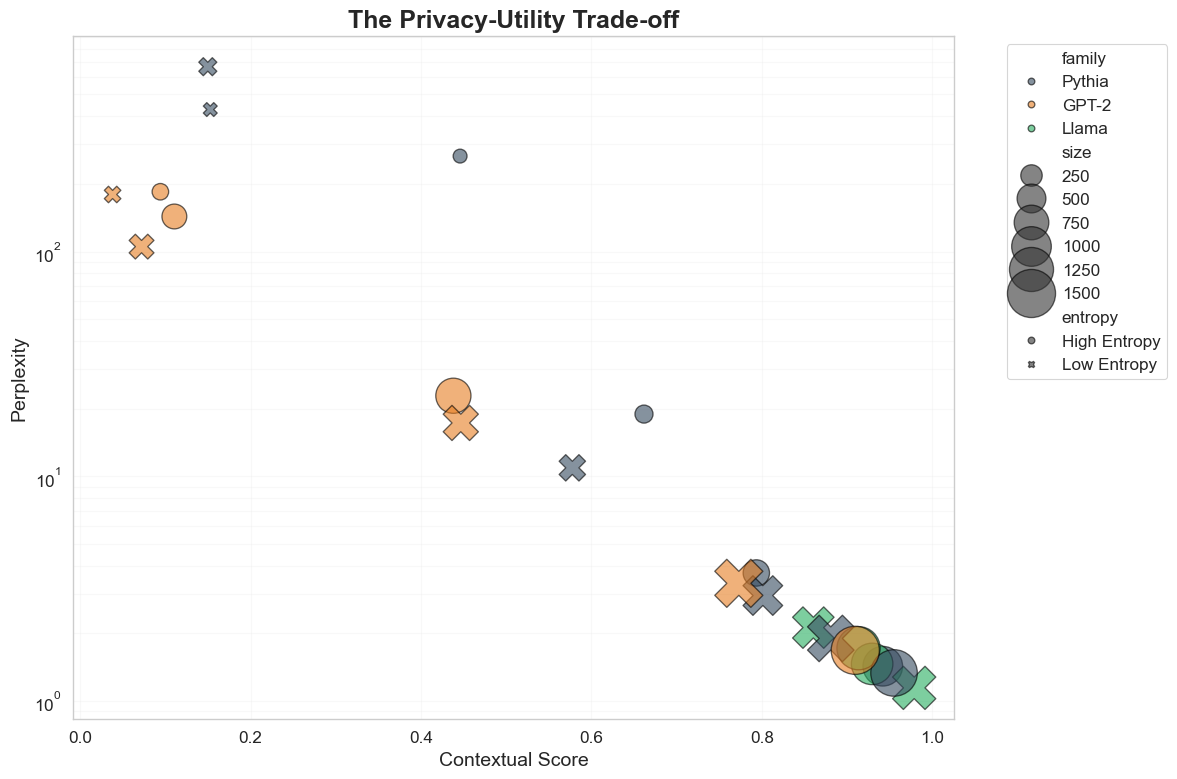

In [39]:
# FIG 3: UTILITY-RISK PARETO FRONTIER
plt.figure(figsize=(12, 8))
# We use size for bubble area and family for color
sns.scatterplot(data=df_master, x='contextual_score', y='perplexity', 
                hue='family', style='entropy', size='size', 
                sizes=(100, 1200), alpha=0.6, edgecolor="black", palette=family_palette)
plt.yscale('log') # Essential for perplexity variations
plt.title("The Privacy-Utility Trade-off", fontsize=18, fontweight='bold')
plt.xlabel("Contextual Score", fontsize=14)
plt.ylabel("Perplexity", fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("fig3_utility_risk_frontier.png")
plt.show()

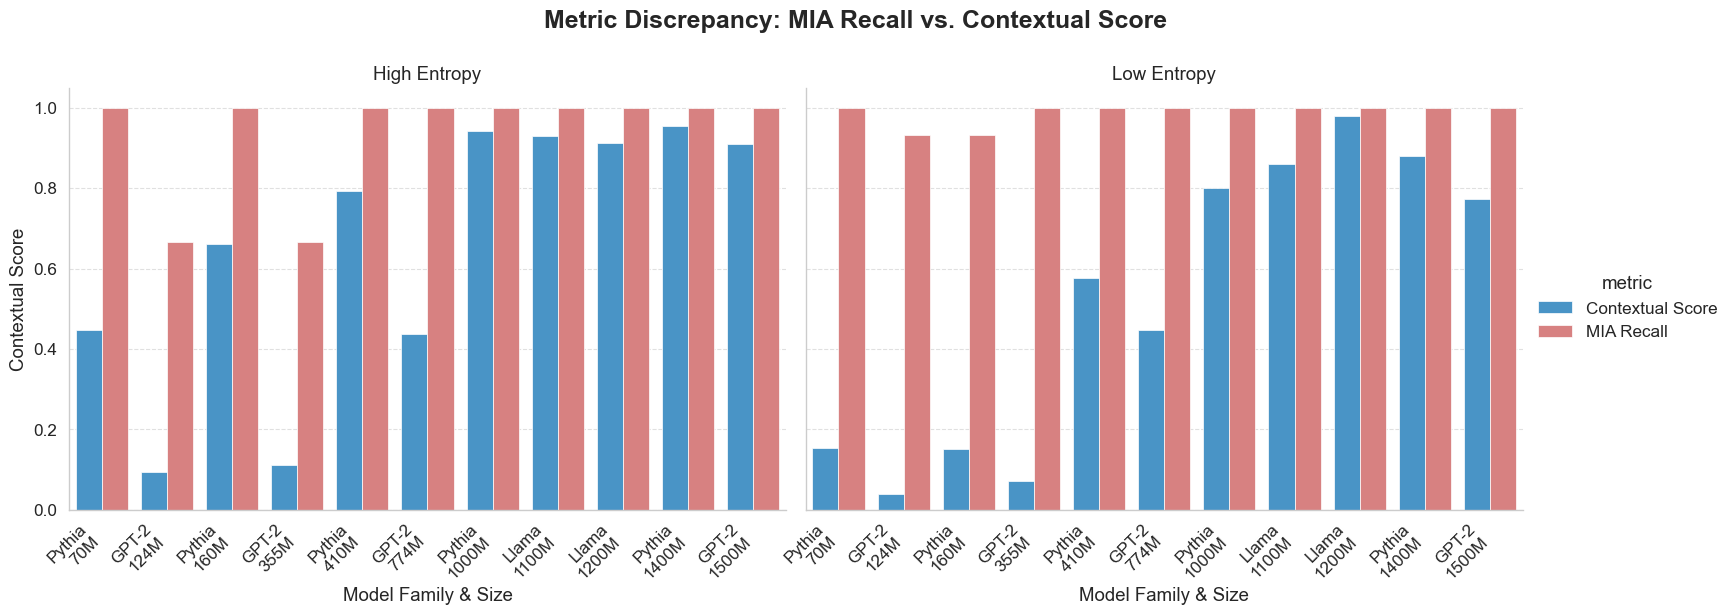

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- FIG 2: THE DISCREPANCY PLOT (Updated with Labels) ---

# 1. PRE-PROCESSING: Creiamo l'etichetta combinata (se non l'hai già fatto prima)
df_master['x_label'] = df_master.apply(lambda row: f"{row['family']}\n{row['size']}M", axis=1)

# 2. ORDINAMENTO: Ordiniamo per dimensione per avere un grafico logico
df_master = df_master.sort_values(by=['size', 'family'])

# 3. MELT DEL DATASET
# IMPORTANTE: Aggiungiamo 'x_label' in id_vars per mantenerlo dopo il melt
df_melt = df_master.melt(id_vars=['x_label', 'size', 'entropy'], 
                         value_vars=['contextual_score', 'mia_recall'], 
                         var_name='metric', value_name='score')

# 4. DEFINIZIONE PALETTE (Soft Red & Soft Blue)
soft_palette = {
    "contextual_score": "#3498db",  # Blu Avio
    "mia_recall":       "#e57373"   # Rosso Corallo
}

# 5. CREAZIONE DEL GRAFICO
g = sns.catplot(
    data=df_melt, 
    x='x_label',   # <--- Usiamo la nuova etichetta combinata
    y='score', 
    hue='metric', 
    col='entropy', 
    kind='bar', 
    palette=soft_palette, 
    height=6,      # Aumentiamo leggermente l'altezza
    aspect=1.3,    # Aumentiamo la larghezza per far entrare le etichette
    edgecolor="white",
    linewidth=0.5
)

# 6. PERSONALIZZAZIONE
g.set_axis_labels("Model Family & Size", "Contextual Score")
g.set_titles("{col_name}")

# Rotazione delle etichette sull'asse X per evitare sovrapposizioni
g.set_xticklabels(rotation=45, ha='right')

# Aggiustiamo la legenda
new_labels = {'contextual_score': 'Contextual Score', 'mia_recall': 'MIA Recall'}
for t, l in zip(g._legend.texts, new_labels.values()):
    t.set_text(l)

# Titolo e salvataggio
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Metric Discrepancy: MIA Recall vs. Contextual Score", fontsize=18, fontweight='bold')

g.savefig("fig2_metric_comparison_labeled.png", dpi=300, bbox_inches='tight')
plt.show()